In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessiondd

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Intro

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print('Shape:', df.shape)
df.head(3)

Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
df = df.drop('Id', axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

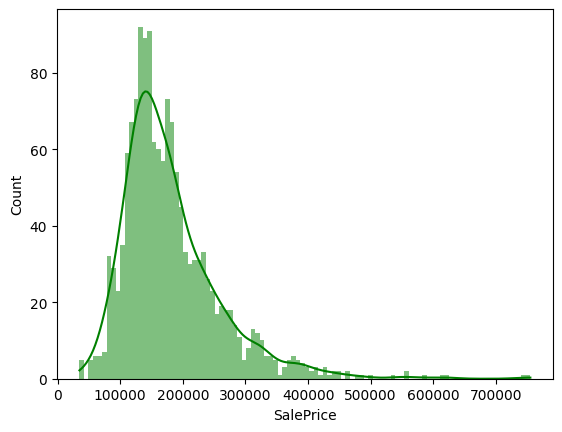

In [6]:
sns.histplot(df['SalePrice'], bins=100, color='g', edgecolor='none', kde=True)

In [7]:
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

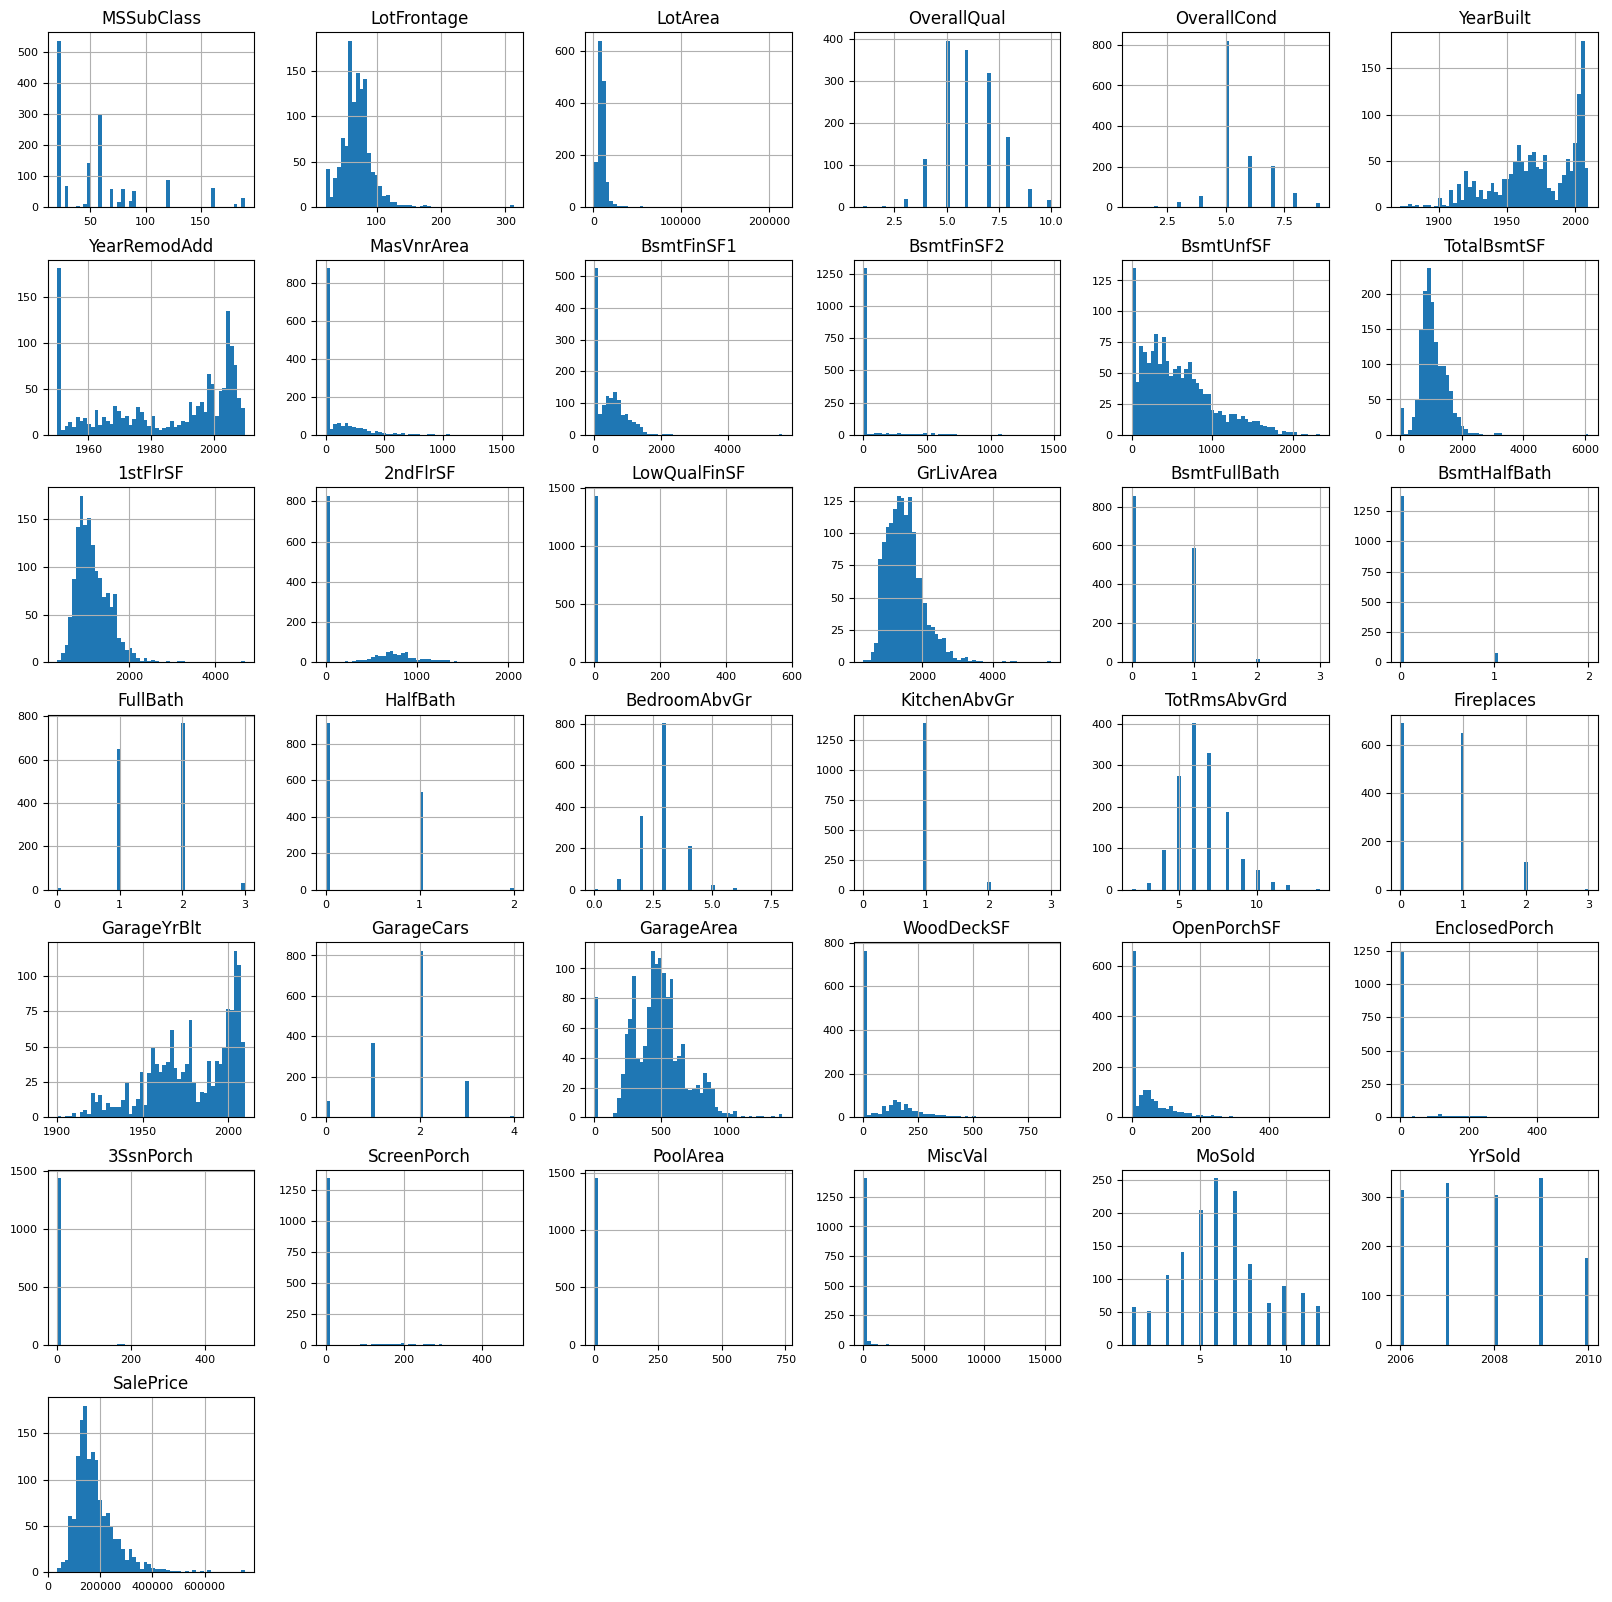

In [8]:
df_num = df.select_dtypes(['float64', 'int64'])
df_num.hist(figsize=(20,20), xlabelsize=8, ylabelsize=8, bins=50);

# Prepare

In [9]:
def split_data(data, test_ratio=0.3):
    test_indices = np.random.rand(len(data)) < test_ratio
    return data[~test_indices], data[test_indices]

train_set, val_set = split_data(df)
print('{} training examples, {} validation examples'.format(len(train_set), len(val_set)))
task=tfdf.keras.Task.REGRESSION
train_set = tfdf.keras.pd_dataframe_to_tf_dataset(train_set, label='SalePrice', task=task)
val_set = tfdf.keras.pd_dataframe_to_tf_dataset(val_set, label='SalePrice', task=task)

1006 training examples, 454 validation examples


# Model

In [10]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [11]:
rf = tfdf.keras.RandomForestModel(task=task)
rf.compile(metrics=['mse'])
rf.fit(train_set)

Use /tmp/tmpzmglp791 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.199869. Found 1006 examples.
Training model...


[INFO 23-11-06 20:14:41.5754 UTC kernel.cc:1243] Loading model from path /tmp/tmpzmglp791/model/ with prefix a3d972cfb1e64349


Model trained in 0:00:01.390542
Compiling model...


[INFO 23-11-06 20:14:41.7694 UTC decision_forest.cc:660] Model loaded with 300 root(s), 95624 node(s), and 74 input feature(s).
[INFO 23-11-06 20:14:41.7694 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-11-06 20:14:41.7694 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [12]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

# Evaluate

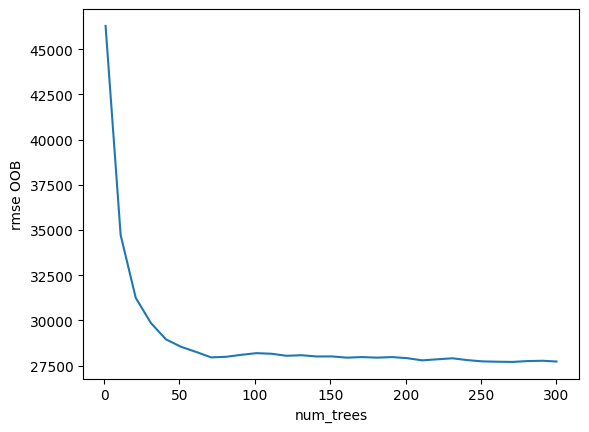

In [13]:
inspector = rf.make_inspector()
logs = inspector.training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel('num_trees')
plt.ylabel('rmse OOB')
plt.show()

In [14]:
inspector.evaluation()

Evaluation(num_examples=1006, accuracy=None, loss=None, rmse=27731.71306173824, ndcg=None, aucs=None, auuc=None, qini=None)

In [15]:
evaluation = rf.evaluate(val_set, return_dict=True)
for name, value in evaluation.items():
    print(name, value)

1/1 [==============================] - 1s 594ms/step - loss: 0.0000e+00 - mse: 968963328.0000
loss 0.0
mse 968963328.0


# Variable Importances

In [16]:
print("Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 SUM_SCORE
	 NUM_AS_ROOT


In [17]:
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

importances_df = pd.DataFrame({"Variable": feature_names, "Importance": feature_importances})

Text(0.5, 1.0, 'Variable Importance Scores')

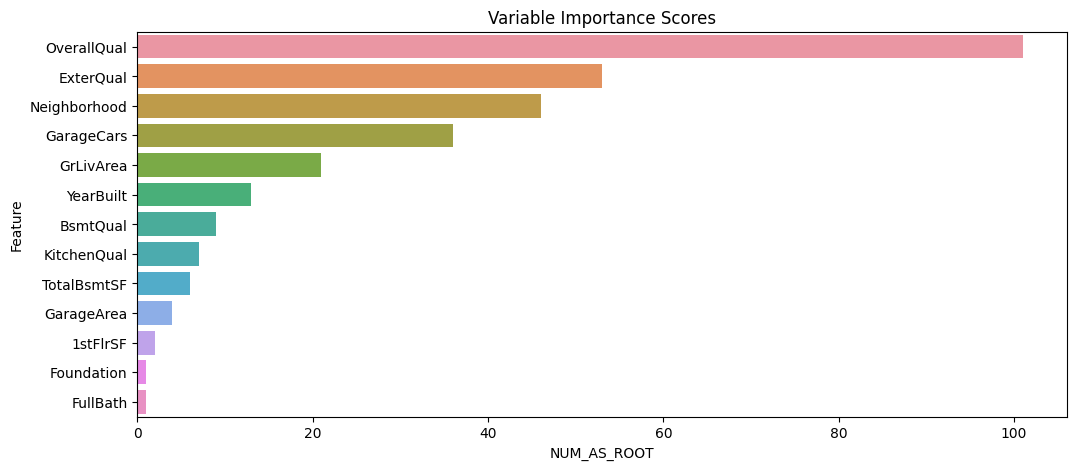

In [18]:
plt.figure(figsize=(12, 5))  # Increase the width (e.g., 10 inches) while keeping the height (e.g., 6 inches)
sns.barplot(x="Importance", y="Variable", data=importances_df)
plt.xlabel(variable_importance_metric)
plt.ylabel("Feature")
plt.title("Variable Importance Scores")

# Submission

In [19]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
# squeeze ensures that the 'SalePrice' column in the output DataFrame has a shape of (n,) and not (n, 1).
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 22ms/step


,Id,SalePrice
0,1461,125897.750000
1,1462,155420.437500
2,1463,181275.437500
3,1464,183142.671875
4,1465,199234.109375
